# <b>Introduction to Statistical Learning, 2nd Edition</b>
## by James, Witten, Hastie, Tibshirani

### Notes by Melis Tekant

## Chapter 5  - Resampling Methods

In [764]:
import pandas as pd
import numpy as np
import matplotlib as mpl
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import random
import scipy.stats as st

In this chapter, two resampling methods will be discussed: cross-validation and bootstrap. These are methods to estimate the test error rate by removing a portion of the training observations from the regression method, then applying it to those points. This can be done for both quantitative and qualitative response.

We can use a validation set approach: randomly dividing the dataset into training and validation. Fit the model on the training set, and predict on the validation set. 

In [137]:
# Using the auto dataset, dropping the bad entries as in Ch 3.

auto = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Auto.csv')
badentry = auto.horsepower.isin(['?'])
badloc = list(badentry[badentry==True].index)
autocl = auto.drop(index=badloc)
autocl.horsepower = pd.to_numeric(autocl.horsepower,errors = 'coerce',downcast = 'integer')
autocl = autocl.reset_index()
autocl = autocl.drop(columns='index',axis =1)

In [143]:
X = autocl[['horsepower']]
y = autocl[['mpg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

polydeg = np.linspace(1,10,10)

mse_poly_1 = []

for deg in polydeg:
    polyreg = PolynomialFeatures(degree = int(deg))
    X_poly = polyreg.fit_transform(X_train)
    X_test_poly = polyreg.fit_transform(X_test)
    linreg = LinearRegression()
    results = linreg.fit(X_poly,y_train)
    y_pred = linreg.predict(X_test_poly)
    mse = np.sum((y_test-y_pred)**2)/len(y_pred)
    mse_poly_1.append(mse)
    
# Repeating different test/validation splits 10 times by not putting a random state number

mse_poly_n = np.zeros((10,len(polydeg)))

for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    for deg in polydeg:
        polyreg = PolynomialFeatures(degree = int(deg))
        X_poly = polyreg.fit_transform(X_train)
        X_test_poly = polyreg.fit_transform(X_test)
        linreg = LinearRegression()
        results = linreg.fit(X_poly,y_train)
        y_pred = linreg.predict(X_test_poly)
        mse = np.sum((y_test-y_pred)**2)/len(y_pred)
        mse_poly_n[i][int(deg-1)] = mse




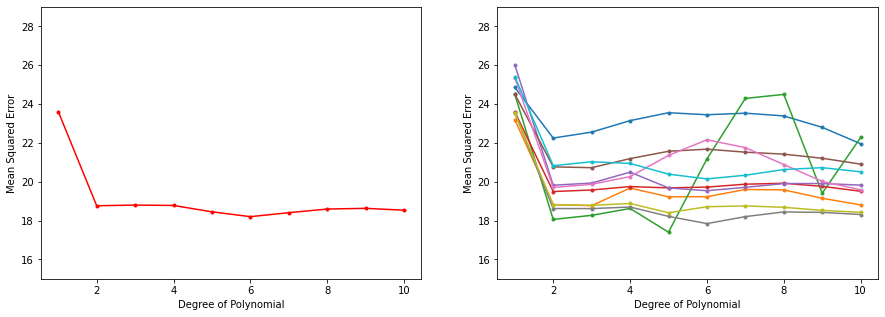

In [144]:
plt.subplots(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(polydeg,mse_poly_1,color='r',marker='.')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.ylim([15,29])

ax2 = plt.subplot(1,2,2)
for i in range(0,10):
    ax2.plot(polydeg,mse_poly_n[i],marker='.')   
ax2.set_xlabel('Degree of Polynomial')
ax2.set_ylabel('Mean Squared Error')
ax2.set_ylim([15,29]);

Instead of splitting the dataset evenly into training and validation sets, we can remove a single point and use the rest of the dataset for training. We can then calculate the MSE for this point, and repeat the same procedure for all the points in the set. This is called leave-one-out-cross-validation method (LOOCV) and tends to not overestimate the MSE as much as the method above.

In [233]:
mse_poly_1 = []

for deg in polydeg:
    mse = 0
    for i in range(0,len(y)):
        X_train, X_test = X.drop(index = i), X.loc[[i]]
        y_train, y_test = y.drop(index = i), y.loc[[i]]
        polyreg = PolynomialFeatures(degree = int(deg))
        X_poly = polyreg.fit_transform(X_train)
        X_test_poly = polyreg.fit_transform(X_test)
        linreg = LinearRegression()
        results = linreg.fit(X_poly,y_train)
        y_pred = linreg.predict(X_test_poly)
        mse = mse + float(((y_test.mpg-float(y_pred))**2/len(y)).values) 
    mse_poly_1.append(mse)

In [299]:
# Repeating above calculation with 10-fold CV

n = 10
mse_poly_n = np.zeros((9,len(polydeg)))
kfold = KFold(n_splits = n,random_state=None,shuffle=True)

for i in range(0,9):
    mse = np.zeros((int(polydeg[-1]),1))
    for train_idx, test_idx in kfold.split(X):
        X_train , X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        for deg in polydeg :
            polyreg = PolynomialFeatures(degree = int(deg))
            X_poly = polyreg.fit_transform(X_train)
            X_test_poly = polyreg.fit_transform(X_test)
            linreg = LinearRegression()
            results = linreg.fit(X_poly,y_train)
            y_pred = linreg.predict(X_test_poly)
            mse[int(deg-1)] = mse[int(deg-1)] + np.sum((y_test-y_pred)**2)/len(y_pred)/n
    mse_poly_n[i][:] = mse.T


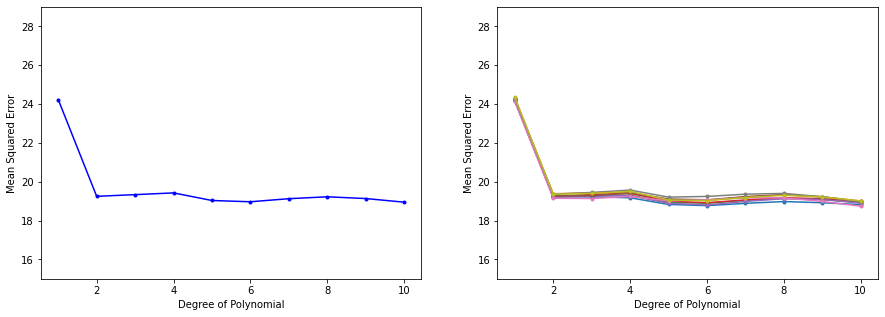

In [300]:
plt.subplots(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(polydeg,mse_poly_1,color='b',marker='.')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.ylim([15,29])

ax2 = plt.subplot(1,2,2)
for i in range(0,9):
    ax2.plot(polydeg,mse_poly_n[i],marker='.')   
ax2.set_xlabel('Degree of Polynomial')
ax2.set_ylabel('Mean Squared Error')
ax2.set_ylim([15,29]);

In the n-fold cross validation method, the sample is separated into n groups. 1 group is held out as a test group while the remaining n-1 groups are used for training. CV is calculated, this is repeated n-1 more times until each group has been used as a test group. The overall CV is calculated by taking the mean of the n calculated CVs. This way, the fit can be performed only n times instead of the number of samples as is required for the LOOCV method -- this might become computationally very intensitve for large datasets. 

Cross-validation is also a good method for classification problems. Instead of MSE, use number (or fraction) of misclassified observations as a metric. LOOCV error rate:

$$CV_{(n)} =\frac{1}{n} \sum_{i=1}^n I(y_i \neq \hat y_i) $$

Now let's simulate data similar to Figure 2.13 to compare logistic regression fits on classification data.

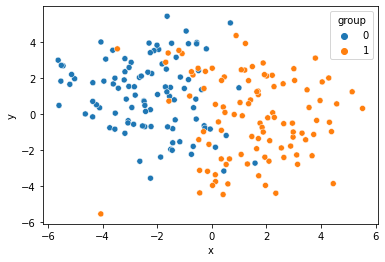

In [629]:
mean1 = [-2.2, 2.5]
cov1 = np.multiply([[1, 0.5], [0.5, 1]],2)
n = 50
x1, y1 = np.random.multivariate_normal(mean1, cov1, n).T
mean2 = [-2.5,0]
cov2 = np.multiply([[1, -0.5], [-0.5, 1]],2)
x2, y2 = np.random.multivariate_normal(mean2, cov2, n).T
mean3 = [2, -2]
cov3 = np.multiply([[1, 0.5], [0.5, 1]],3)
x3, y3 = np.random.multivariate_normal(mean3, cov3, n).T
mean4 = [1,1.5]
cov4 = np.multiply([[1, -0.5], [-0.5, 1]],3)
x4, y4 = np.random.multivariate_normal(mean4, cov4, n).T

data1 = pd.DataFrame([x1,y1],index = ['x','y'])
data2=pd.DataFrame([x2,y2],index = ['x','y'])
data_l = pd.concat([data1,data2],axis=1,ignore_index=True)
data_l=data_l.T
data_l['group'] = 0

data3 = pd.DataFrame([x3,y3],index = ['x','y'])
data4=pd.DataFrame([x4,y4],index = ['x','y'])
data_r = pd.concat([data3,data4],axis=1,ignore_index=True)
data_r=data_r.T
data_r['group'] = 1

data_all = pd.concat([data_l,data_r],ignore_index = True)
sns.scatterplot(data=data_all,x='x',y='y',hue='group');

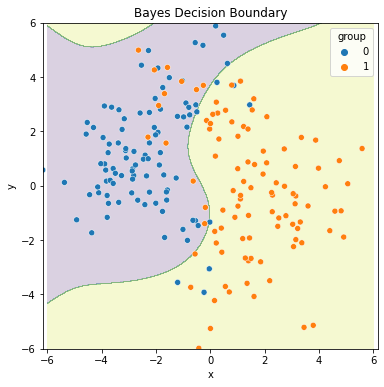

In [614]:
xes ,ys = np.mgrid[-6:6:0.01,-6:6:0.01]
pos = np.dstack((xes,ys))
rv_1 = multivariate_normal(mean1,cov1)
pdf_1 = rv_1.pdf(pos)
rv_2 = multivariate_normal(mean2,cov2)
pdf_2 = rv_2.pdf(pos)

rv_3 = multivariate_normal(mean3,cov3)
pdf_3 = rv_3.pdf(pos)
rv_4 = multivariate_normal(mean4,cov4)
pdf_4 = rv_4.pdf(pos)

img = -pdf_1-pdf_2+pdf_3+pdf_4
img[img<0] = 0
img[img>0] = 1

plt.figure(figsize=(6,6))
plt.contourf(xes,ys,img,alpha=0.2)
sns.scatterplot(data=data_all,x='x',y='y',hue='group')
plt.axis('equal')
plt.ylim(-6,6)
plt.xlim(-6,6)
plt.title('Bayes Decision Boundary');

In [615]:
def Logistic_Reg_pred(X, y, deg, X_test):
    polyregn = PolynomialFeatures(degree=deg)
    X_polyn = polyregn.fit_transform(X)
    polyreg = LogisticRegression(max_iter = 1000000)
    polyreg.fit(X_polyn,y)
    X_testn = polyregn.fit_transform(X_test)
    y_pred_poly_n = polyreg.predict(X_testn)
    return y_pred_poly_n

def Logistic_Reg_plot(X,y,deg,xx,yy):
    polyregn = PolynomialFeatures(degree=deg)
    X_polyn = polyregn.fit_transform(X)
    polyreg = LogisticRegression(max_iter=1000)
    polyreg.fit(X_polyn,y)
    xx1 = np.c_[xx.ravel(),yy.ravel()]
    xxn = polyregn.fit_transform(xx1)
    Z = polyreg.predict(xxn)
    Zn = Z.reshape(xx.shape)
    plt.contourf(xx,yy,Zn,alpha=0.2,cmap = 'jet')

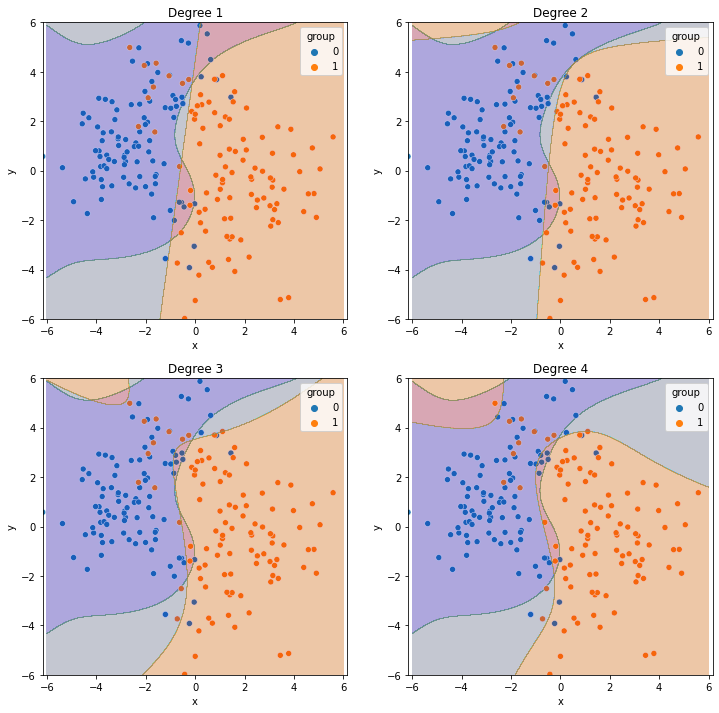

In [616]:
plt.subplots(figsize=(12,12))
degs = [1,2,3,4]

for i in range(0,len(degs)):
    plt.subplot(2,2,i+1)
    plt.contourf(xes,ys,img,alpha=0.2)
    sns.scatterplot(data=data_all,x='x',y='y',hue='group')
    deg = degs[i]
    X = data_all.drop(columns='group',axis=1)
    y = data_all['group']
    Logistic_Reg_plot(X,y,deg,xes,ys)
    plt.axis('equal')
    plt.ylim(-6,6)
    plt.xlim(-6,6)
    plt.title('Degree ' +str(degs[i]));

In [617]:
degs = [1,2,3,4]
for i in range(0,len(degs)):
    deg = degs[i]
    ypred = Logistic_Reg_pred(X,y,deg,X)
    accuracy = accuracy_score(y,ypred)
    error = 1-accuracy
    print('Logistic regression of degree '+ str(deg) + ' has an error rate of ' +str(round(error,3))+'.')

Logistic regression of degree 1 has an error rate of 0.125.
Logistic regression of degree 2 has an error rate of 0.1.
Logistic regression of degree 3 has an error rate of 0.12.
Logistic regression of degree 4 has an error rate of 0.105.


In [619]:
# Make a test set
n = 20
x1, y1 = np.random.multivariate_normal(mean1, cov1, n).T
mean2 = [-2.5,0]
cov2 = np.multiply([[1, -0.5], [-0.5, 1]],2)
x2, y2 = np.random.multivariate_normal(mean2, cov2, n).T
mean3 = [2, -2]
cov3 = np.multiply([[1, 0.5], [0.5, 1]],3)
x3, y3 = np.random.multivariate_normal(mean3, cov3, n).T
mean4 = [1,1.5]
cov4 = np.multiply([[1, -0.5], [-0.5, 1]],3)
x4, y4 = np.random.multivariate_normal(mean4, cov4, n).T

data1 = pd.DataFrame([x1,y1],index = ['x','y'])
data2=pd.DataFrame([x2,y2],index = ['x','y'])
data_l = pd.concat([data1,data2],axis=1,ignore_index=True)
data_l=data_l.T
data_l['group'] = 0

data3 = pd.DataFrame([x3,y3],index = ['x','y'])
data4=pd.DataFrame([x4,y4],index = ['x','y'])
data_r = pd.concat([data3,data4],axis=1,ignore_index=True)
data_r=data_r.T
data_r['group'] = 1

data_all = pd.concat([data_l,data_r],ignore_index = True)
X_test = data_all.drop(columns='group',axis=1)
y_test = data_all['group']


/Users/melistekant/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/melistekant/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

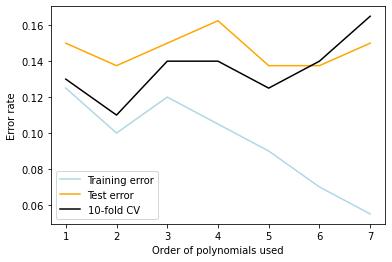

In [620]:
degs = np.arange(1,8,1)
errtrain = np.zeros(len(degs))
errtest = np.zeros(len(degs)) 
X_test = data_all.drop(columns='group',axis=1)
y_test = data_all['group']

for i in range(0,len(degs)):
    deg = degs[i]
    ypred = Logistic_Reg_pred(X,y,deg,X)
    accuracy = accuracy_score(y,ypred)
    errtrain[i] = 1-accuracy
    ypred = Logistic_Reg_pred(X,y,deg,X_test)
    accuracy = accuracy_score(y_test,ypred)
    errtest[i] = 1-accuracy
    
# Repeating above calculation with 10-fold CV

n = 10
err_cv = np.zeros(len(degs))
kfold = KFold(n_splits = n,random_state=None,shuffle=True)

for i in range(0,len(degs)):
    deg = degs[i]
    errs = []
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        ypred = Logistic_Reg_pred(X_train,y_train,deg,X_test)
        accuracy = accuracy_score(y_test,ypred)
        errs.append(1-accuracy)
    err_cv[i] = np.mean(errs)
    
plt.plot(degs, errtrain, c='lightblue',label='Training error')
plt.plot(degs,errtest, c= 'orange',label = 'Test error')
plt.plot(degs,err_cv, c= 'k',label = '10-fold CV')
plt.xlabel('Order of polynomials used')
plt.ylabel('Error rate')
plt.legend();


In [621]:
def KNN_Class_pred(X, y, k, X_test):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X,y)
    y_pred_n = neigh.predict(X_test)
    return y_pred_n

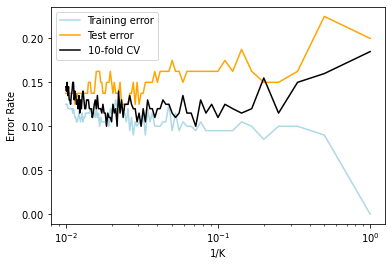

In [622]:
ks = np.arange(1,101,1)
errtrain = np.zeros(len(ks))
errtest = np.zeros(len(ks))
X_test = data_all.drop(columns='group',axis=1)
y_test = data_all['group']

for i in range(0,len(ks)):
    k = ks[i]
    ypred = KNN_Class_pred(X,y,k,X)
    accuracy = accuracy_score(y,ypred)
    errtrain[i] = 1-accuracy
    ypred = KNN_Class_pred(X,y,k,X_test)
    accuracy = accuracy_score(y_test,ypred)
    errtest[i] = 1-accuracy
    
err_cv = np.zeros(len(ks))
kfold = KFold(n_splits = n,random_state=None,shuffle=True)
    
for i in range(0,len(ks)):
    k = ks[i]
    errs = []
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        ypred = KNN_Class_pred(X_train,y_train,k,X_test)
        accuracy = accuracy_score(y_test,ypred)
        errs.append(1-accuracy)
    err_cv[i] = np.mean(errs)
    
    
plt.plot(1/ks, errtrain, c='lightblue',label='Training error')
plt.plot(1/ks,errtest, c= 'orange',label = 'Test error')
plt.plot(1/ks,err_cv,c='k',label='10-fold CV')
plt.xscale('log')
plt.ylabel('Error Rate')
plt.xlabel('1/K')
plt.legend();


The Bootstrap is a tool used to quantify the uncertainty of a given estimator or learning model.

Say money will be split between two investment strategies X and Y with fraction $\alpha$ and $1-\alpha$ respectively. The variance is minimized for

$$ \alpha = \frac{\sigma_Y^2 -Cov(X,Y)}{\sigma_X^2+\sigma_Y^2 -2Cov(X,Y)}.$$

For unknown $\sigma_i$ and covarience, estimates are used, which gives an estimate for $\alpha$, $\hat \alpha$. To estimate the standard deviation of $\hat \alpha$, simulate 100 paired observations of X and Y and estimate $\alpha$.

In [665]:
npts = 100
nsims = 1000
alpha = np.zeros(nsims)
mean = [0,0]
cov = [[1, 0.5], [0.5, 1.25]]
alpha_real = (1.25-0.5)/(1+1.25-2*0.5)

for i in range(0,nsims):
    x, y = np.random.multivariate_normal(mean, cov, npts).T
    varx = np.var(x)
    vary = np.var(y)
    varxy = np.cov([x,y])[1,0]
    alpha[i] = (vary - varxy)/(varx+vary-2*varxy)


Instead of repeatedly sampling new points, which may not be possible in reality, we can resample from the original dataset. We randomly select n observations from the data, with replacement (so the same point can appear more than once in the bootstrap set). This can be done a large number of times, each time making an estimate for $\alpha$. Now these estimates can be used to compute a standard error and find the estimate and spread of $\hat \alpha$.

In [689]:
x, y = np.random.multivariate_normal(mean, cov, npts).T
alpha_boot = np.zeros(nsims)

for i in range(0,nsims):
    xsim = []
    ysim = []
    for j in range(0,100):
        k = random.randrange(0,len(x))
        xsim.append(x[k])
        ysim.append(y[k])
    varx = np.var(xsim)
    vary = np.var(ysim)
    varxy = np.cov([xsim,ysim])[1,0]
    alpha_boot[i] = (vary - varxy)/(varx+vary-2*varxy)
    

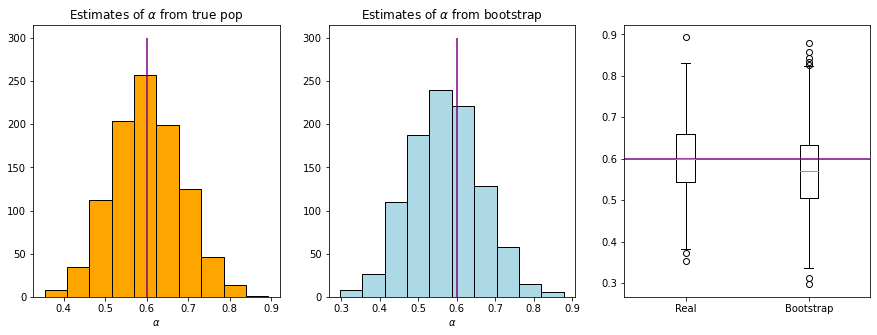

In [739]:
plt.subplots(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(alpha,bins=10,color='orange',edgecolor='k')
plt.vlines(alpha_real,0,300,color='purple')
plt.title('Estimates of ' r'$\alpha$' ' from true pop')
plt.xlabel(r'$\alpha$')
plt.subplot(1,3,2)
plt.hist(alpha_boot,bins=10,color='lightblue',edgecolor='k')
plt.vlines(alpha_real,0,300,color='purple')
plt.title('Estimates of ' r'$\alpha$' ' from bootstrap')
plt.xlabel(r'$\alpha$')

ax = plt.subplot(1,3,3)
plt.boxplot([alpha,alpha_boot])    
ax.set_xticklabels(['Real','Bootstrap'])
plt.axhline(alpha_real,color='purple');


Exercises:

9.

In [740]:
boston = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Boston.csv')

In [745]:
boston = boston.drop(columns='Unnamed: 0',axis=1)

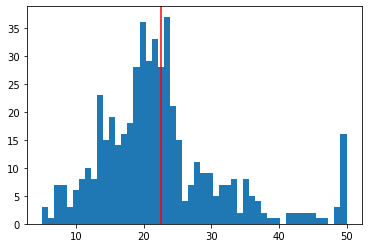

In [755]:
medv_mean = np.mean(boston['medv'])
plt.hist(boston['medv'],bins=50);
plt.axvline(medv_mean,color='red');

In [756]:
medv_std = np.std(boston['medv'])
medv_ste = medv_std/np.sqrt(len(boston['medv']))
medv_ste

0.4084569346972867

The standard error is quite small, so most of the values are centered around the value of medv_mean (22.532).

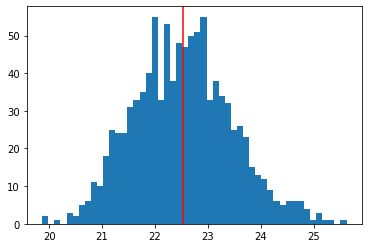

In [768]:
medv_boot = np.zeros(nsims)

for i in range(0,nsims):
    musim = []
    for j in range(0,100):
        k = random.randrange(0,len(boston['medv']))
        musim.append(boston.medv[k])
    medv_boot[i]=np.mean(musim)
    
plt.hist(medv_boot,bins=50);
plt.axvline(medv_mean,color='red');

In [769]:
medv_std_boot = np.std(medv_boot)
medv_ste_boot = medv_std_boot/np.sqrt(len(medv_boot))
medv_ste_boot

0.029389650955923247

Bootstrapping gives a significantly smaller standard error on the mean.

In [777]:
(np.mean(medv_boot)-2*medv_ste_boot,np.mean(medv_boot)+2*medv_ste_boot)

(22.47308769808815, 22.590646301911846)

In [776]:
st.t.interval(alpha=0.95,df = len(boston['medv'])-1,loc = medv_mean,scale = medv_ste)

(21.730322160407493, 23.335290487813904)

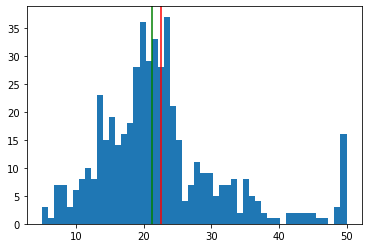

In [780]:
medv_median = np.median(boston['medv'])
plt.hist(boston['medv'],bins=50);
plt.axvline(medv_mean,color='red');
plt.axvline(medv_median,color='green');

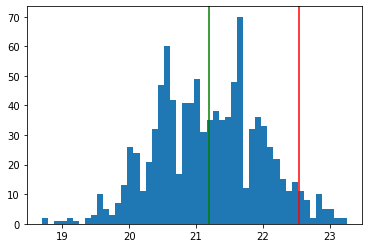

In [786]:
medv_med_boot = np.zeros(nsims)

for i in range(0,nsims):
    medsim = []
    for j in range(0,100):
        k = random.randrange(0,len(boston['medv']))
        medsim.append(boston.medv[k])
    medv_med_boot[i]=np.median(medsim)
    
plt.hist(medv_med_boot,bins=50);
plt.axvline(medv_mean,color='red');
plt.axvline(medv_median,color='green');

In [787]:
medv_med_std_boot = np.std(medv_med_boot)
medv_med_ste_boot = medv_med_std_boot/np.sqrt(len(medv_med_boot))
medv_med_ste_boot

0.02481906117281634

standard error of the median from bootstrapping is very close to that of the mean from bootstrapping.

In [789]:
tenth_perc = np.quantile(boston['medv'],0.1)

In [791]:
tenth_perc_boot = np.zeros(nsims)

for i in range(0,nsims):
    quantsim = []
    for j in range(0,100):
        k = random.randrange(0,len(boston['medv']))
        quantsim.append(boston.medv[k])
    tenth_perc_boot[i]=np.quantile(quantsim,0.1)
    
tenth_boot_ste = np.std(tenth_perc_boot)/np.sqrt(len(tenth_perc_boot))
tenth_boot_ste

0.03446646629841824

The standard error on the tenth percentile of 'medv' in Boston census tract is larger than that of the mean of the same data. 